In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=5cb4e98821e6ec5941be900e1eadcedef31e60f3a9a0606fd0b5c020ee5aff0d
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
filename = "email-Eu-core-temporal.txt"

In [3]:
import pyspark
import itertools
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Window 
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read data

In [4]:
conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf = conf)

# create a spark session
spark = SparkSession.builder.appName('link-prediction').getOrCreate()

In [5]:
# read data as list
with open(filename) as csvfile:
    data = [list(map(int, row)) for row in csv.reader(csvfile, delimiter=' ')]

# make a spark dataframe
columns = ["u", "v", "t"]
df = spark.createDataFrame(data=data, schema=columns)

df.toPandas()

,u,v,t
0,163,164,24892
1,163,123,24892
2,163,147,24892
3,163,75,24892
4,134,145,26648
...,...,...,...
46767,168,135,45314032
46768,9,56,45320940
46769,56,135,45321233
46770,56,135,45321386


# Select based on timeframe

In [6]:
train_df = df.filter(F.col("t") < 20_000_000)
test_df = df.filter(F.col("t") >= 20_000_000).filter(F.col("t") < 22_000_000)

train_df.toPandas(), test_df.toPandas()

(         u    v         t
 0      163  164     24892
 1      163  123     24892
 2      163  147     24892
 3      163   75     24892
 4      134  145     26648
 ...    ...  ...       ...
 18199  103  135  19986743
 18200  103   87  19986743
 18201    9   56  19990053
 18202   87   56  19994530
 18203   87   56  19994532
 
 [18204 rows x 3 columns],
        u    v         t
 0     70  171  20003392
 1     28   75  20003895
 2     28  134  20006641
 3     28  164  20006641
 4     28  163  20006641
 ...   ..  ...       ...
 2890  56  135  21923923
 2891  56   87  21923923
 2892  56  168  21930108
 2893  56  135  21930108
 2894  56   87  21930108
 
 [2895 rows x 3 columns])

In [7]:
nodes = train_df\
  .select("u")\
  .union(train_df.select("v"))\
  .withColumnRenamed("u", "node")\
  .distinct().orderBy("node")

edges = train_df\
  .drop("t")\
  .groupby("u", "v")\
  .count()

maxCount = edges\
  .select(
      F.max(edges["count"]).alias("maxCount")
  ).collect()[0]["maxCount"]

# nodes = train_df\
#   .select("u")\
#   .union(edges.select("v"))\
#   .withColumnRenamed("u", "node")\
#   .orderBy("node")

all_node_pairs = nodes.withColumnRenamed("node", "u")\
  .join(nodes.withColumnRenamed("node", "v"))
  
num_nodes = nodes.count()

nodes.toPandas()

,node
0,0
1,1
2,2
3,3
4,5
...,...
131,167
132,168
133,169
134,170


## SimRank

In [8]:
gamma = train_df\
    .select(F.col("u").alias("v"), F.col("v").alias("u"))\
    .union(train_df.select(F.col("u"), F.col("v")))\
    .groupby("u")\
    .agg(F.collect_list("v").alias("edges"))\
    .select(F.col("u").alias("node"), F.array_distinct("edges").alias("gamma"), F.size(F.col("edges")).alias("degree"))\
    .select("node", "gamma", F.size("gamma").alias("gamma_size"), "degree")\
    .filter(F.size("gamma") > 2)

gamma.toPandas()

,node,gamma,gamma_size,degree
0,0,"[28, 144, 134, 122, 147, 145, 119, 171]",8,72
1,2,"[40, 142, 24, 91, 63, 94, 30, 57, 146, 18, 153...",15,898
2,3,"[82, 39, 47, 86, 137, 165, 64, 35, 52, 92, 14,...",18,300
3,5,"[165, 33, 86, 14, 92, 137, 39, 130, 141]",9,214
4,7,"[140, 27, 156, 77, 23, 155, 80, 44, 126, 36, 1...",12,368
...,...,...,...,...
103,167,"[68, 94, 146, 43, 65, 63, 153, 24, 91, 148, 97...",15,606
104,168,"[135, 56, 103, 9, 121, 87]",6,162
105,169,"[171, 144, 147, 122, 163, 134, 145]",7,60
106,170,"[148, 65, 43, 76, 78, 97]",6,116


In [9]:
k = 0.8
iterations = 5

In [10]:
A_adj_neighbours = gamma.select(F.col('node').alias('u'), F.explode('gamma').alias('v'))
A_adj = A_adj_neighbours.join(gamma, (A_adj_neighbours.v==gamma.node), 'left').select(A_adj_neighbours.u, A_adj_neighbours.v, gamma.gamma_size)

A_adj = all_node_pairs.join(A_adj, (A_adj.u==all_node_pairs.u) & (A_adj.v==all_node_pairs.v), 'left')\
                  .select(all_node_pairs.u, all_node_pairs.v, (1/F.col('gamma_size')).alias('value')).fillna(0).fillna("0")\
                  .orderBy('u', 'v')
A_adj.toPandas()

,u,v,value
0,0,0,0.000000
1,0,1,0.000000
2,0,2,0.000000
3,0,3,0.000000
4,0,5,0.000000
...,...,...,...
18491,171,167,0.000000
18492,171,168,0.000000
18493,171,169,0.142857
18494,171,170,0.000000


In [11]:
simrank_adj = all_node_pairs.select('u', 'v', F.when(F.col('u') == F.col('v'), 1)\
  .otherwise(0).alias('simrank'))\
  .orderBy('u','v')

simrank_adj.toPandas()

,u,v,simrank
0,0,0,1
1,0,1,0
2,0,2,0
3,0,3,0
4,0,5,0
...,...,...,...
18491,171,167,0
18492,171,168,0
18493,171,169,0
18494,171,170,0


In [12]:
A_w = Window.partitionBy("u").orderBy("v")

A = A_adj\
  .withColumn("sorted_list", F.collect_list("value").over(A_w))\
  .groupBy("u")\
  .agg(F.max("sorted_list").alias('row'))\
  .orderBy('u')\
  .withColumn("id", F.monotonically_increasing_id())
  
A.toPandas()

,u,row,id
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
3,3,"[0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, ...",3
4,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
...,...,...,...
131,167,"[0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0,...",131
132,168,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14285714...",132
133,169,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",133
134,170,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",134


In [13]:
simrank_w = Window.partitionBy("u").orderBy("v")

simrank = simrank_adj\
  .withColumn("sorted_list", F.collect_list("simrank").over(simrank_w))\
  .groupBy("u")\
  .agg(F.max("sorted_list").alias('row'))\
  .orderBy('u')\
  .withColumn("id", F.monotonically_increasing_id())
  
simrank.toPandas()

,u,row,id
0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
3,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,5,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
...,...,...,...
131,167,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",131
132,168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",132
133,169,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",133
134,170,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",134


In [14]:
A_matrix = IndexedRowMatrix(A.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)

simrank_matrix = IndexedRowMatrix(simrank.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)

c_np = k*np.eye(num_nodes)
C = IndexedRowMatrix(sc.parallelize([IndexedRow(i, c_np[i]) for i in range(num_nodes)]))\
  .toBlockMatrix(num_nodes, num_nodes)

In [15]:
for i in range(iterations):
  simrank_matrix = C.multiply(A_matrix.transpose().multiply(simrank_matrix).multiply(A_matrix))

In [16]:
schema = T.StructType([
    T.StructField('Id', T.IntegerType(), True),
    T.StructField('row', T.ArrayType(T.FloatType()), True)
])
simrank = spark.createDataFrame(simrank_matrix.toIndexedRowMatrix().rows.map(lambda ele: (ele.index, ele.vector.toArray().tolist())),\
                                schema)

In [17]:
simrank_scores = simrank.join(A, (simrank.Id == A.id)).select(A.u, simrank.row)\
                  .select('u', F.posexplode_outer("row")).withColumnsRenamed({'u':'node1', 'pos':'vid','col':'simrank'})

simrank_scores = simrank_scores.join(A, (simrank_scores.vid == A.id))\
                  .select(simrank_scores.node1, A.u.alias('node2'), simrank_scores.simrank)\
                  .select(F.concat(F.col("node1"), F.lit(","), F.col("node2")).alias("u,v"), 'simrank')

simrank_scores.toPandas()

,"u,v",simrank
0,"0,0",0.010633
1,"0,1",0.000000
2,"0,2",0.000000
3,"0,3",0.000000
4,"0,5",0.000000
...,...,...
18491,"171,167",0.000000
18492,"171,168",0.000000
18493,"171,169",0.017473
18494,"171,170",0.000000


## Katz

In [18]:
_katz_adj = nodes.withColumnRenamed("node", "_u")\
  .join(nodes.withColumnRenamed("node", "_v"))\
  .orderBy("_u", "_v")

beta = 1 / (1.5 * maxCount)

katz_edges = edges\
  .withColumn("value", edges["count"] * beta)\
  .drop("count")

katz_adj = _katz_adj\
  .join(
    katz_edges, 
    (_katz_adj._u == katz_edges.u)
      & (_katz_adj._v == katz_edges.v),
    'left'
  )\
  .select("_u", "_v", "value")\
  .fillna(0)\
  .withColumnRenamed("_u", "u")\
  .withColumnRenamed("_v", "v")

katz_adj.orderBy("u", "v").toPandas()

,u,v,value
0,0,0,0.000000
1,0,1,0.000000
2,0,2,0.000000
3,0,3,0.000000
4,0,5,0.000000
...,...,...,...
18491,171,167,0.000000
18492,171,168,0.000000
18493,171,169,0.021322
18494,171,170,0.000000


In [19]:
katz_w = Window.partitionBy("u").orderBy("v")
_katz_A = katz_adj\
  .withColumn("sorted_list", F.collect_list("value").over(katz_w))\
  .groupBy("u")\
  .agg(F.max("sorted_list").alias('row'))\
  .orderBy('u')\
  .withColumn("id", F.monotonically_increasing_id())
_katz_A.toPandas()

,u,row,id
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004...",2
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
4,5,"[0.0, 0.0, 0.0, 0.0014214641080312722, 0.0, 0....",4
...,...,...,...
131,167,"[0.0, 0.0, 0.0014214641080312722, 0.0, 0.0, 0....",131
132,168,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01421464...",132
133,169,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",133
134,170,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",134


In [20]:
katz_A = IndexedRowMatrix(_katz_A.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)
katz_matrix = IndexedRowMatrix(_katz_A.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)
katz_scores = IndexedRowMatrix(sc.parallelize([IndexedRow(_, [0] * num_nodes) for _ in range(num_nodes)]))\
  .toBlockMatrix(num_nodes, num_nodes)
katz_A.toLocalMatrix().toArray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02558635],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00142146, 0.        , 0.        , ..., 0.02132196, 0.        ,
        0.        ]])

In [21]:
for i in range(100):
  katz_scores = katz_scores.add(katz_matrix)
  katz_matrix = katz_matrix.multiply(katz_A)

In [22]:
schema = T.StructType([
    T.StructField('Id', T.IntegerType(), True),
    T.StructField('row', T.ArrayType(T.FloatType()), True)
])
katz_scores = spark.createDataFrame(katz_scores.toIndexedRowMatrix().rows.map(lambda ele: (ele.index, ele.vector.toArray().tolist())),\
                                schema)

In [23]:
katz_scores.toPandas()

,Id,row
0,19,"[0.03645440563559532, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,39,"[0.0, 0.001533163944259286, 0.0, 0.0, 0.0, 0.0..."
2,34,"[0.0, 0.0, 0.0011090516345575452, 0.0, 0.0, 0...."
3,101,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[0.0, 0.0, 0.0, 0.0029918383806943893, 0.00200..."
...,...,...
131,8,"[0.0, 0.0, 4.205246925354004, 0.0, 0.0, 0.0, 0..."
132,44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
133,88,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
134,68,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
katz_scores = katz_scores.join(_katz_A, (katz_scores.Id == _katz_A.id)).select(_katz_A.u, katz_scores.row)\
                  .select('u', F.posexplode_outer("row")).withColumnsRenamed({'u':'node1', 'pos':'vid','col':'katz'})

katz_scores = katz_scores.join(_katz_A, (katz_scores.vid == _katz_A.id))\
                  .select(katz_scores.node1, _katz_A.u.alias('node2'), katz_scores.katz)\
                  .select(F.concat(F.col("node1"), F.lit(","), F.col("node2")).alias("u,v"), 'katz')

katz_scores.toPandas()

,"u,v",katz
0,"0,0",0.000121
1,"0,1",0.000000
2,"0,2",0.000000
3,"0,3",0.000000
4,"0,5",0.000000
...,...,...
18491,"171,167",0.000000
18492,"171,168",0.000000
18493,"171,169",0.021618
18494,"171,170",0.000000


In [25]:
all_scores = katz_scores.join(simrank_scores, (simrank_scores['u,v'] == katz_scores['u,v'])).select(simrank_scores['u,v'], simrank_scores.simrank, katz_scores.katz)

all_scores.toPandas()

,"u,v",simrank,katz
0,"0,160",0.0,0.0
1,"3,24",0.0,0.0
2,"3,69",0.0,0.0
3,"5,74",0.0,0.0
4,"10,28",0.0,0.0
...,...,...,...
18491,"165,50",0.0,0.0
18492,"166,63",0.0,0.0
18493,"168,140",0.0,0.0
18494,"169,30",0.0,0.0


## Testing

In [26]:
keys = ['simrank', 'katz']

predictions = list(map(lambda key: all_scores\
    .orderBy(F.col(key).desc())\
    .select("u,v")\
    .rdd\
    .map(lambda row: row[0])\
    .collect(), keys))

In [27]:
labels = test_df\
    .filter(F.col("u") < F.col("v"))\
    .select((F.concat(F.col("u"), F.lit(","), F.col("v"))).alias("u,v"))\
    .union(
        test_df\
        .filter(F.col("u") > F.col("v"))\
        .select((F.concat(F.col("v"), F.lit(","), F.col("u"))).alias("u,v"))\
    )\
    .distinct();
    
labels = labels\
    .rdd\
    .map(lambda row: row[0])\
    .collect()

len(labels)

379

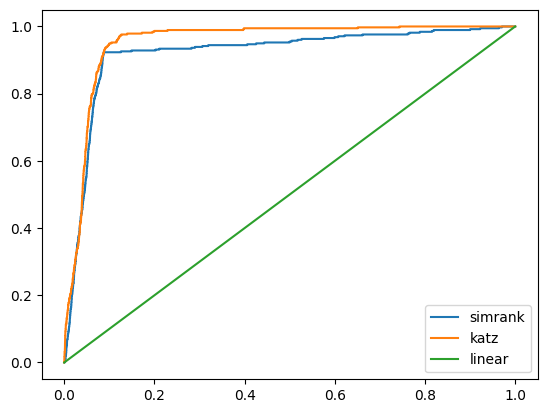

<Figure size 640x480 with 0 Axes>

In [28]:
def roc(pairs, labels):
    labels = set(labels).intersection(set(pairs))
    
    #  threshold = infinite
    tp, fp, fn, tn = 0, 0, len(labels), len(pairs) - len(labels) 
    
    fprs, tprs = [], []
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    for pair in pairs:
        if pair in labels:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        fprs.append(fp / (fp + tn + 1e-10))
        tprs.append(tp / (tp + fn + 1e-10))
        
    tp, fp ,fn, tn = len(labels), len(pairs) - len(labels), 0, 0
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    return fprs, tprs

auc_scores = {}
for key, prediction in zip(keys, predictions):
    fprs, tprs = roc(prediction, labels)
    auc_scores[key] = np.trapz(tprs, fprs)
    plt.plot(fprs, tprs, label=key)
plt.plot(np.arange(len(fprs))/len(fprs), np.arange(len(fprs))/len(fprs), label="linear")
plt.legend()
plt.show()
plt.clf()

In [29]:
pd.DataFrame(auc_scores.items(), columns=['Algorithm', 'AUC Score'])

,Algorithm,AUC Score
0,simrank,0.920197
1,katz,0.952648
